In [1]:

import os,sys
import cv2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.python.keras import models,losses,layers, backend as K
import tensorflow.contrib.eager as tfe

# Eager execution is the first thing to be executed in a program thus executing at start.
tf.enable_eager_execution()
print(tf.executing_eagerly())


True


In [16]:

import numpy as np 
import pandas as pd 

from subprocess import check_output
#print(check_output(["ls", "/input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

In [17]:
import os
#os.listdir("/input")

In [4]:
def load_img(imgPath,targetShape):
    img = cv2.imread(imgPath,cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(targetShape[0],targetShape[1]))
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

def deprocess_img(processed_img):
    x = processed_img.copy()  
    # perform the inverse of the preprocessiing step
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [5]:
dataHome = "/input"
content_img_path = dataHome + "/selfpics/index.png"
style_img_path = dataHome + "/style-transfer/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg"

In [9]:
# Load content img and style img
target_shape = (512,512,3)

#G = np.random.randint(0,255,(*target_shape,)).astype(np.float32)
G = load_img(content_img_path,target_shape).astype(np.float32)
C = load_img(content_img_path,target_shape).astype(np.float32)
S = load_img(style_img_path,target_shape).astype(np.float32)

In [10]:
print(G.shape,C.shape,S.shape)

(512, 512, 3) (512, 512, 3) (512, 512, 3)


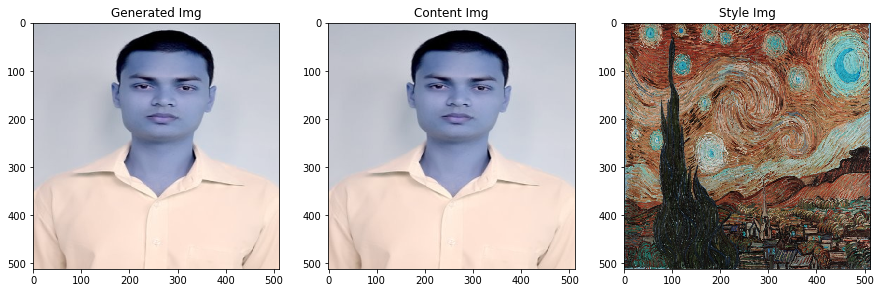

In [11]:
# Display all 3 images.
fig = plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(deprocess_img(G))
plt.title("Generated Img")

plt.subplot(1,3,2)
plt.imshow(deprocess_img(C))
plt.title("Content Img")

plt.subplot(1,3,3)
plt.imshow(deprocess_img(S))
plt.title("Style Img")

plt.show()

In [12]:
# Use VGG model as default model.

modelVGG = tf.keras.applications.VGG19(include_top=False,weights="imagenet")
for layer in modelVGG.layers:
    layer.trainable = False

# specify names of style and content output layers.
content_layers = ['block5_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']

# Get outputs of content and style layers.
content_outputs = [modelVGG.get_layer(name).output for name in content_layers]
style_outputs = [modelVGG.get_layer(name).output for name in style_layers]

# Concatenate style and content outputs to create all outputs.
all_outputs = style_outputs + content_outputs

# Create final model.
model = models.Model(modelVGG.input,all_outputs)

for layer in model.layers:
    layer.trainable = False
    print(layer.name,layer.output.shape,"Trainable:",layer.trainable)

80142336/80134624 [==============================] - 1s 0us/step
input_1 (?, ?, ?, 3) Trainable: False
block1_conv1 (?, ?, ?, 64) Trainable: False
block1_conv2 (?, ?, ?, 64) Trainable: False
block1_pool (?, ?, ?, 64) Trainable: False
block2_conv1 (?, ?, ?, 128) Trainable: False
block2_conv2 (?, ?, ?, 128) Trainable: False
block2_pool (?, ?, ?, 128) Trainable: False
block3_conv1 (?, ?, ?, 256) Trainable: False
block3_conv2 (?, ?, ?, 256) Trainable: False
block3_conv3 (?, ?, ?, 256) Trainable: False
block3_conv4 (?, ?, ?, 256) Trainable: False
block3_pool (?, ?, ?, 256) Trainable: False
block4_conv1 (?, ?, ?, 512) Trainable: False
block4_conv2 (?, ?, ?, 512) Trainable: False
block4_conv3 (?, ?, ?, 512) Trainable: False
block4_conv4 (?, ?, ?, 512) Trainable: False
block4_pool (?, ?, ?, 512) Trainable: False
block5_conv1 (?, ?, ?, 512) Trainable: False
block5_conv2 (?, ?, ?, 512) Trainable: False


In [13]:
def get_content_loss(G_output,C_output):
    '''
    Computes MSE loss between output of G and C images.
    '''
    return tf.reduce_mean(tf.square(G_output - C_output))

def gram_matrix(eager_tensor):
    '''
    Computes gram matrix for given tensor of dim: h,w,c.
    Output gram matrix has shape c,c. For Gram matrix conversion first matrix is converted to shape h*w,c then then
    multiplied with its transpose, resulting in output of shape c,c.
    '''
    #tensor = tensor.astype(np.float32)
    h,w,c = eager_tensor.shape
    a = tf.reshape(eager_tensor,(-1,c))
    denominator = a.shape[0]
    gram = tf.matmul(a,a,transpose_a=True)
    #return gram / tf.cast(denominator * 4.0 ,dtype=tf.float32)
    return gram

def get_style_loss(G_output,S_output):
    '''
    Style loss is MSE between Gram matrices of G_output and S_output for a single layer.
    '''
    # Convert G_output and S_output to gram matrices.
    G_gram = gram_matrix(G_output)
    S_gram = gram_matrix(S_output)
    h,w,c = G_output.shape
    N_l = c
    M_l = h*w
    deno = 4.0 * (N_l) * (M_l )
    print("deno:",deno)
    style_loss = tf.reduce_mean(tf.square(G_gram - S_gram)) / tf.cast(deno,dtype=tf.float32)
    #style_loss = tf.reduce_mean(tf.square(G_gram - S_gram)) 
    return style_loss

def compute_grads(G_,S_outputs,C_outputs):
    with tf.GradientTape() as tape:
        G_outputs = model(G_)
        G_style_outputs = [output[0] for output in G_outputs[:len(S_outputs)]] # Extract style output part from all G outputs.
        G_content_outputs = [output[0] for output in G_outputs[len(S_outputs):]] # Extract content output part from all G outputs.
        # Compute style loss and content loss.
        S_loss= 0.0
        alpha_per_layer = 1.0 / float(len(S_outputs))
        for s_out,g_style_out in zip(S_outputs,G_style_outputs):
            S_loss += alpha_per_layer * get_style_loss(g_style_out,s_out)
        C_loss = 0.0
        beta_per_layer = 1.0 / float(len(C_outputs))
        for c_out,g_content_out in zip(C_outputs,G_content_outputs):
            C_loss += beta_per_layer * get_content_loss(g_content_out,c_out)
            
        total_loss = alpha * S_loss + beta * C_loss
    # Compute gradients of total_loss w.r.t Generated image.
    grads = tape.gradient(total_loss,G_)
    return grads,total_loss,S_loss,C_loss



In [14]:
import IPython

# start training.
epochs = 1000
alpha = 1e-2 # Weight of style loss in total loss.
beta = 1e3 # Weight of content loss in total loss.
opt = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)




# As only G image is to be optimized thus convert it to tensorflow eager variable.
G_ = tfe.Variable(G[None,:,:,:],dtype=tf.float32,name="G_")
S_ = S[None,:,:,:]
C_ = C[None,:,:,:]

# Get style features for S and content features for C from model.

S_outputs = [output[0] for output in model(S_)[:len(style_layers)]] # Removing first dim of num_batches
C_outputs = [output[0] for output in model(C_)[len(style_layers):]] # Removing first dim of num_batche
print("Generated features for Style and Content")

best_loss,best_img = float("inf"),None
hist={
    "loss":[],
    "S_loss":[],
    "C_loss":[]
}

norm_means = np.array([103.939, 116.779, 123.68])
min_vals = -norm_means
max_vals = 255 - norm_means 


Generated features for Style and Content


Epoch 1000/1000 total_loss:906658.125 S_loss:31426048.0 C_loss:592.397705078125


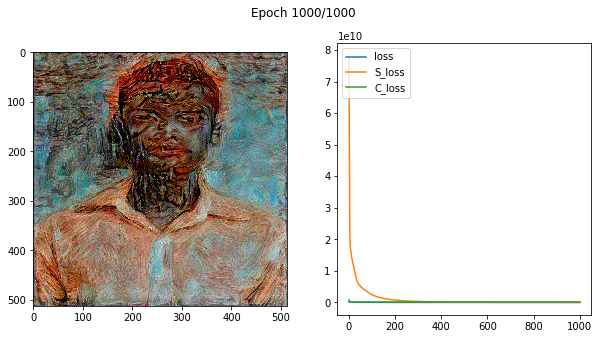

In [15]:

best_loss,best_img = float('inf'),None
for epoch in range(epochs):
    # Compute total loss with GradientTape
    grads,total_loss,S_loss,C_loss = compute_grads(G_,S_outputs,C_outputs)
    hist["loss"].append(total_loss)
    hist["S_loss"].append(S_loss)
    hist["C_loss"].append(C_loss)
    #print(total_loss,S_loss,C_loss)

    # Applyc gradients to Generated image.
    opt.apply_gradients([(grads,G_)])
    
    # Clip image pixles in given range.
    clipped = tf.clip_by_value(G_, min_vals, max_vals)
    # Update Generated image.
    G_.assign(clipped)
    
    # Create image to be printed.
    printImg = G_.numpy()[0]
    printImg = deprocess_img(printImg)
    
    if total_loss < best_loss:
        best_loss = total_loss
        best_img = printImg
    
    # Print results.
    IPython.display.clear_output(wait=True)
    print("Epoch {}/{} total_loss:{} S_loss:{} C_loss:{}".format(epoch+1,epochs,total_loss,S_loss,C_loss))
    fig = plt.figure(figsize=(10,5))
    fig.suptitle("Epoch {}/{}".format(epoch+1,epochs))
    
    plt.subplot(1,2,1)
    #plt.imshow(tf.identity(G_[0].numpy().astype(np.uint8)))
    plt.imshow(printImg)
    
    plt.subplot(1,2,2)
    plt.plot(hist["loss"],label="loss")
    plt.plot(hist["S_loss"],label="S_loss")
    plt.plot(hist["C_loss"],label="C_loss")
    plt.legend(loc="upper left")
    plt.show()


In [ ]:
plt.imshow(best_img)
plt.title("Best Img")
plt.show()